### Trajectory analysis of Breast Cancer using PILOT-GM-VAE

In this notebook, we demonstrate the entire process of training the model and applying **PILOT-GM-VAE** to single-cell RNA sequencing (scRNA-seq) data using Breast Cancer scRNA data. 
You can download the required AnnData (h5ad) file from the following link:  
[Breast Cancer scRNA Data on Zenodo](https://zenodo.org/records/14615923)

In [2]:
from pilot_gm_vae import *
import scanpy as sc

### Reading Anndata

In [3]:
file_path = 'BreastCncr_processed.h5ad'
adata=sc.read_h5ad(file_path)

### Loading the Required Information for Training the Model

To work with **PILOT-GM-VAE**, ensure that your AnnData object is loaded and contains the required information. Use the following parameters to configure **PILOT-GM-VAE** for your analysis:

#### **Setting Parameters**
- **`adata`**:  
  Pass your loaded AnnData object to **PILOT-GM-VAE**.

- **`dataset_name`**:  
  Name of the dataset for saving the model in the `trained_models` folder.

- **`pca_key`**:  
  Provide the name of the variable in the `obsm` attribute that holds the dimensionality reduction (e.g., PCA representation).

- **`load_weights`**:  
  Load pre-trained weights if available. If the model has already been trained, set this to `True`.

- **`num_classes`**:  
  Number of components. For example, for Breast Cancer scRNA-seq data, set this to `10`, which corresponds to the approximate number of cell types in the dataset.

#### **Pre-Trained Weights and Distance Estimation**
In this tutorial, we have already provided:
1. Pre-trained weights for the model to simplify the setup.
2. Pre-computed distances between samples (EMD) for faster analysis. Note, if you want to train the model, please skip loading the EMD.

#### **Optional Hyperparameters**
You can modify other hyperparameters based on your needs, such as:
- Number of training epochs.
- Size of the neural network layers.
- Learning rate, batch size, etc.

Make sure to adjust these parameters to tailor the model to your dataset and analysis objectives.


In [4]:
model = train_gmvae(
    adata=adata,
    dataset_name= "Breast",
    pca_key= 'X_pca_harmony',
    load_weights= True,
    num_classes= 10,
    epochs= 100
)

Loaded pre-trained weights from ./trained_models/Breast/gmvae_weights.pth.
Performing inference...
Done!


In [5]:
adata.uns['EMD']= np.load('trained_models/Breast/EMD.npy')

#### Estimating Distances Between Samples with the Wasserstein Distance

Use the following parameters to configure **PILOT-GM-VAE** for your analysis:

#### **Setting Parameters**
- **`adata`**:  
  Pass your loaded AnnData object to **PILOT-GM-VAE**.

- **`emb_matrix`**:  
  Provide the name of the variable in the `obsm` attribute that holds the dimensionality reduction (e.g., PCA representation).

- **`sample_col`**:  
  Specify the column name in the observation (`obs`) level of your AnnData object that contains information about samples or patients.

- **`status`**:  
  Indicate the column name that represents the status or disease (e.g., "control" or "case").

- **`wass_dis`**:  
  - Set this to `True` if you need to compute the distances between samples using the Wasserstein distance.
  - Set this to `False` if the distances (e.g., EMD) have already been computed and loaded, such as in the example above where we loaded the pre-computed EMD matrix.

In [8]:
gmmvae_wasserstein_distance(adata,
emb_matrix = 'X_pca_harmony',
sample_col = 'accSample',
status = 'accLabel',
wass_dis= False)

### Trajectory Analysis

In this section, we visualize the diffusion map of the Wasserstein distance to analyze the trajectory of the samples.


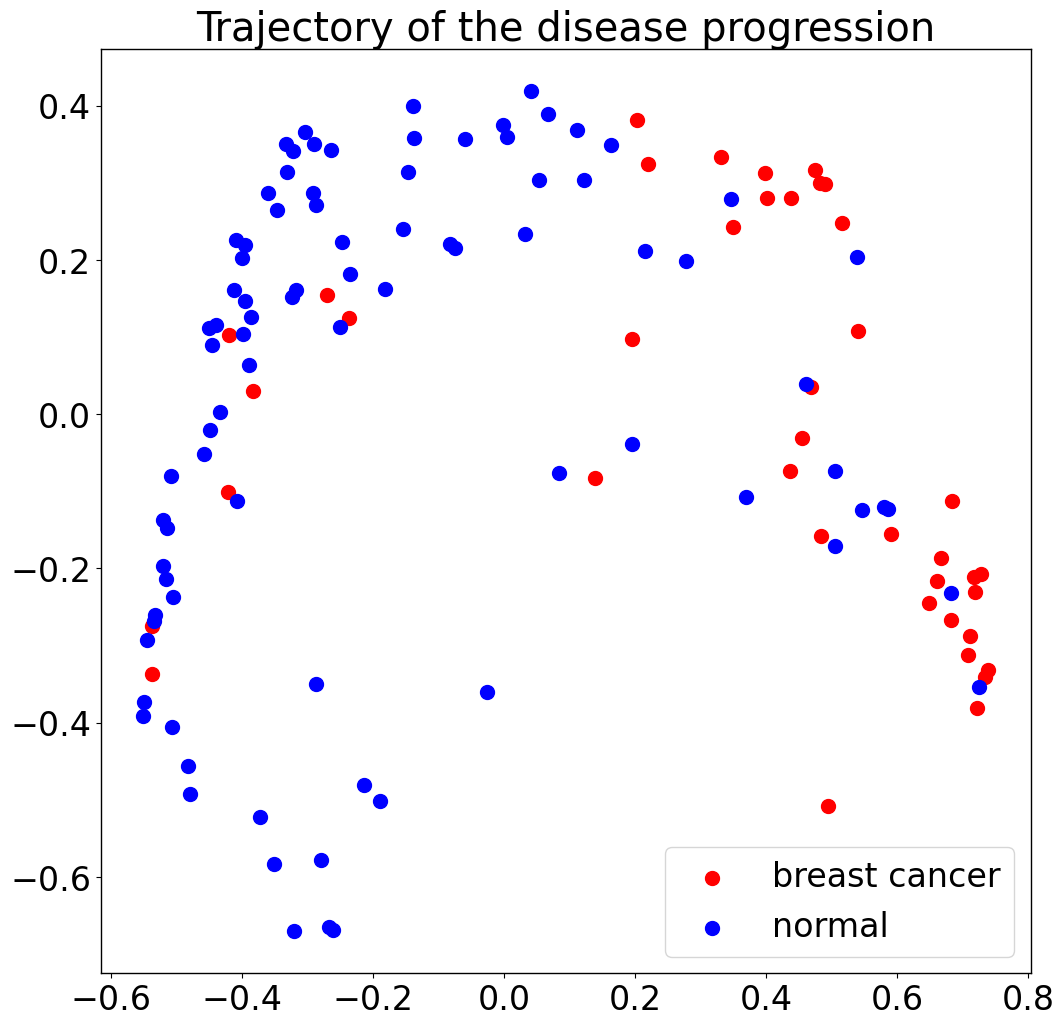

In [9]:
trajectory(adata, colors = ['red','blue','green','yellow','pink'],location_labels= 'best',knn= 8)

#### Fitting a Principal Graph

The diffusion map creates an embedding that potentially reveals a trajectory in the data. Next, **PILOT-GM-VAE** utilizes **EIPLGraph** to uncover the structure of this trajectory.

#### Key Parameter:
- **`source_node`**:  
  This parameter indicates the starting point of the trajectory. For example, in this analysis, we select a normal sample as the source node (`node with id = 0`).

This method outputs ranked samples, which we define as a **disease progression score** (t = t1, ..., tn), where \(t_n\) represents the ranking of the \(n\)-th sample along the trajectory.


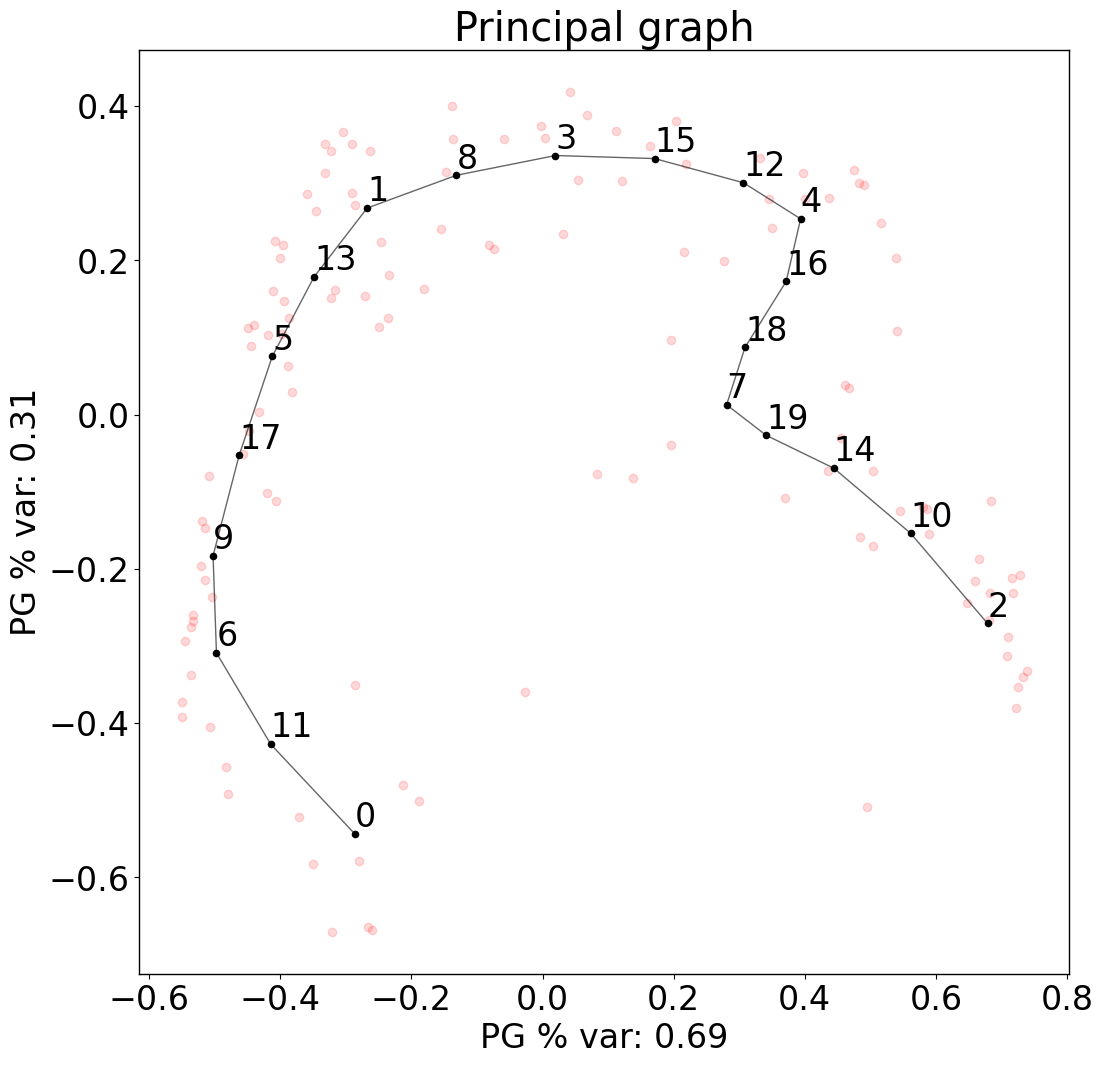

In [10]:
fit_pricipla_graph(adata, source_node = 0)

### Checking the Consistency Between the Found Components and the Cell Types

To proceed with this analysis, please ensure the column name for **`cell_type_col`** is correctly set in your `adata` object.

#### Steps:
1. **Coloring the UMAP**:  
   - We visualize the UMAP, coloring it based on the components identified by the model and the cell types.
   - This allows us to evaluate how well the identified components align with the known cell types.

2. **Annotating Components**:  
   - For components that perfectly match specific cell types, we can annotate them accordingly.
   - This helps improve interpretability of the results.


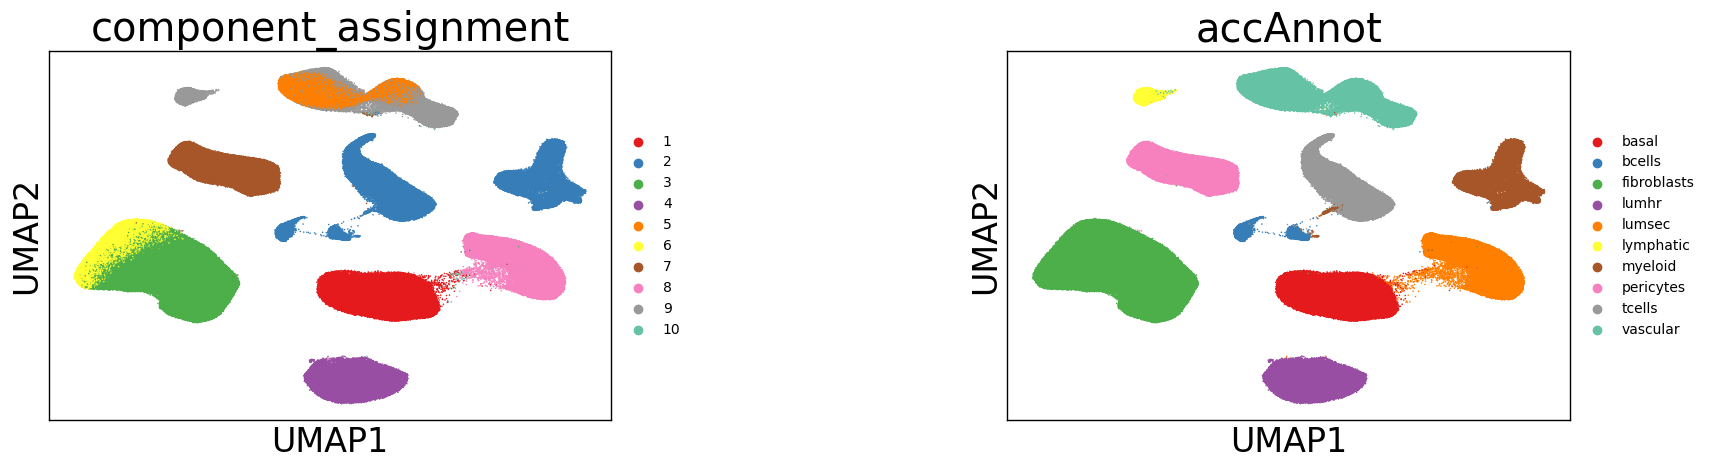

<Figure size 1400x800 with 0 Axes>

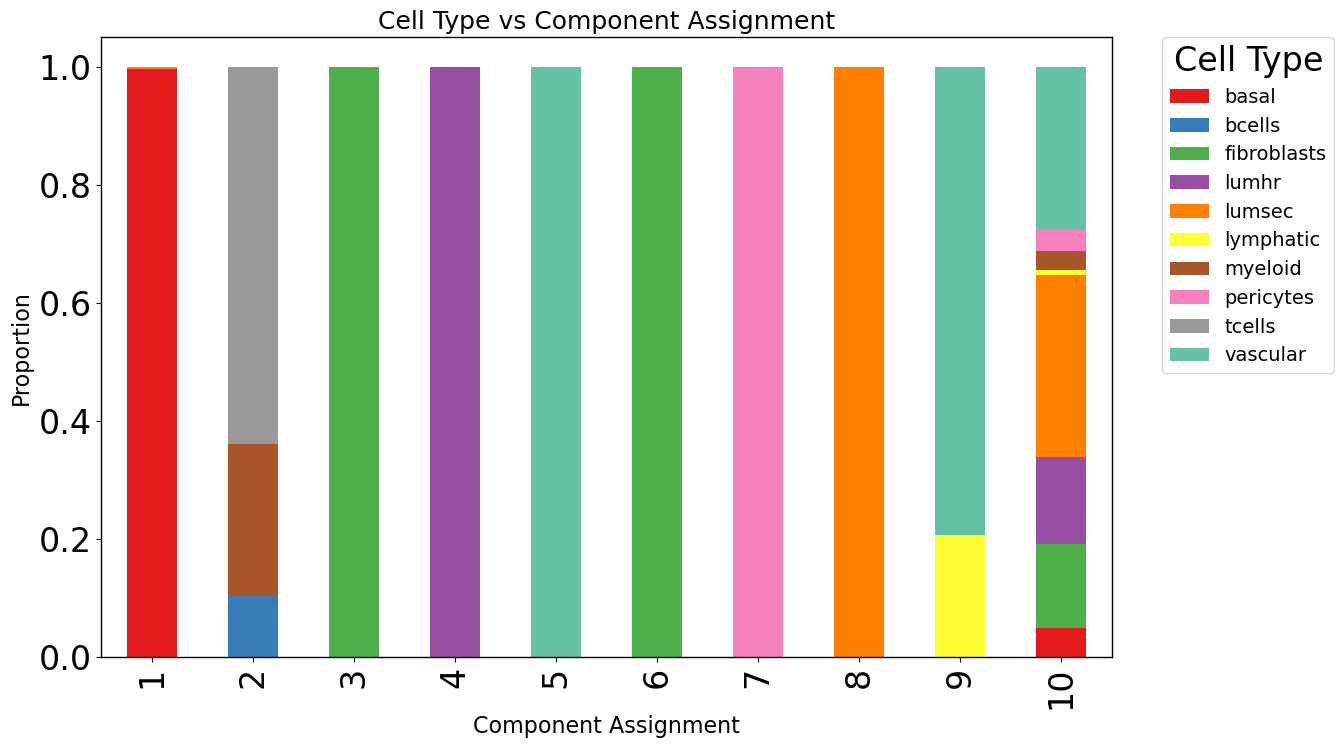

In [11]:
plot_umap_and_stacked_bar(adata,cell_type_col= 'accAnnot')

#### Annotation

Based on the matches observed in the bar plots and UMAP visualization, we can proceed with annotating the identified components. 


In [12]:
component_to_celltype = {
    '1': 'basal',
    '2': 'immune_cells',
    '3': 'fibroblasts_1',
    '4': 'lumhr',
    '5': 'vascular',
    '6': 'fibroblasts_2',
    '7': 'pericytes',
    '8': 'lumsec',
    '9': 'Endothelial',
    '10':'mix'
}
adata.obs['component_renamed'] = adata.obs['component_assignment'].map(component_to_celltype)

### Component importance
Next, we can use the robust regression model to find components whose proportions change linearly or non-linearly with disease progression. 

In [13]:
gmmvae_wasserstein_distance(adata,
clusters_col= 'component_renamed',
emb_matrix = 'X_pca_harmony',
sample_col = 'accSample',
status = 'accLabel',
wass_dis= False)

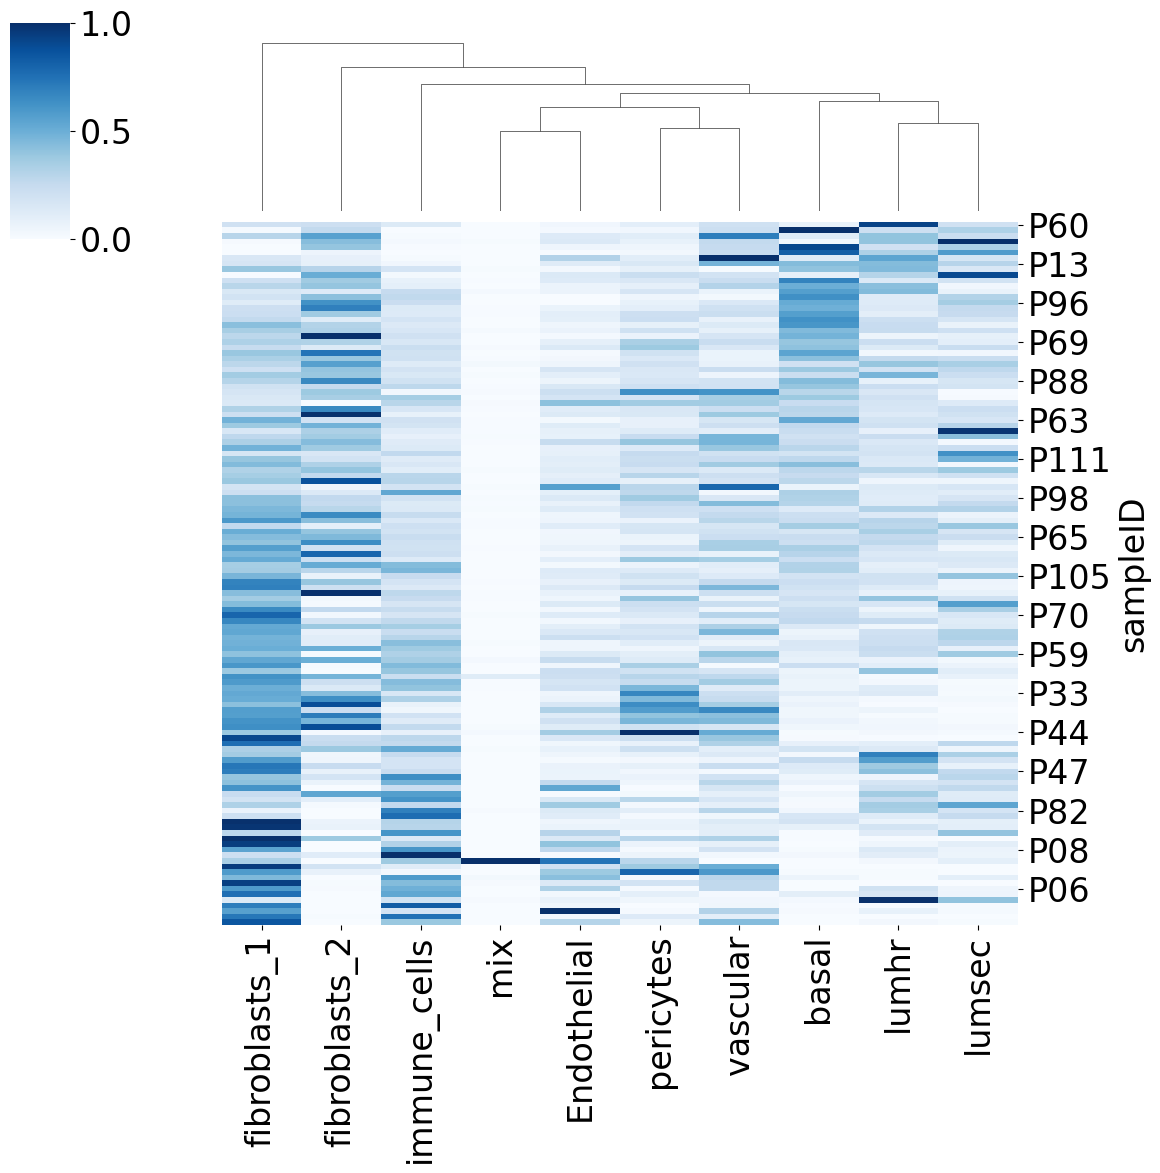

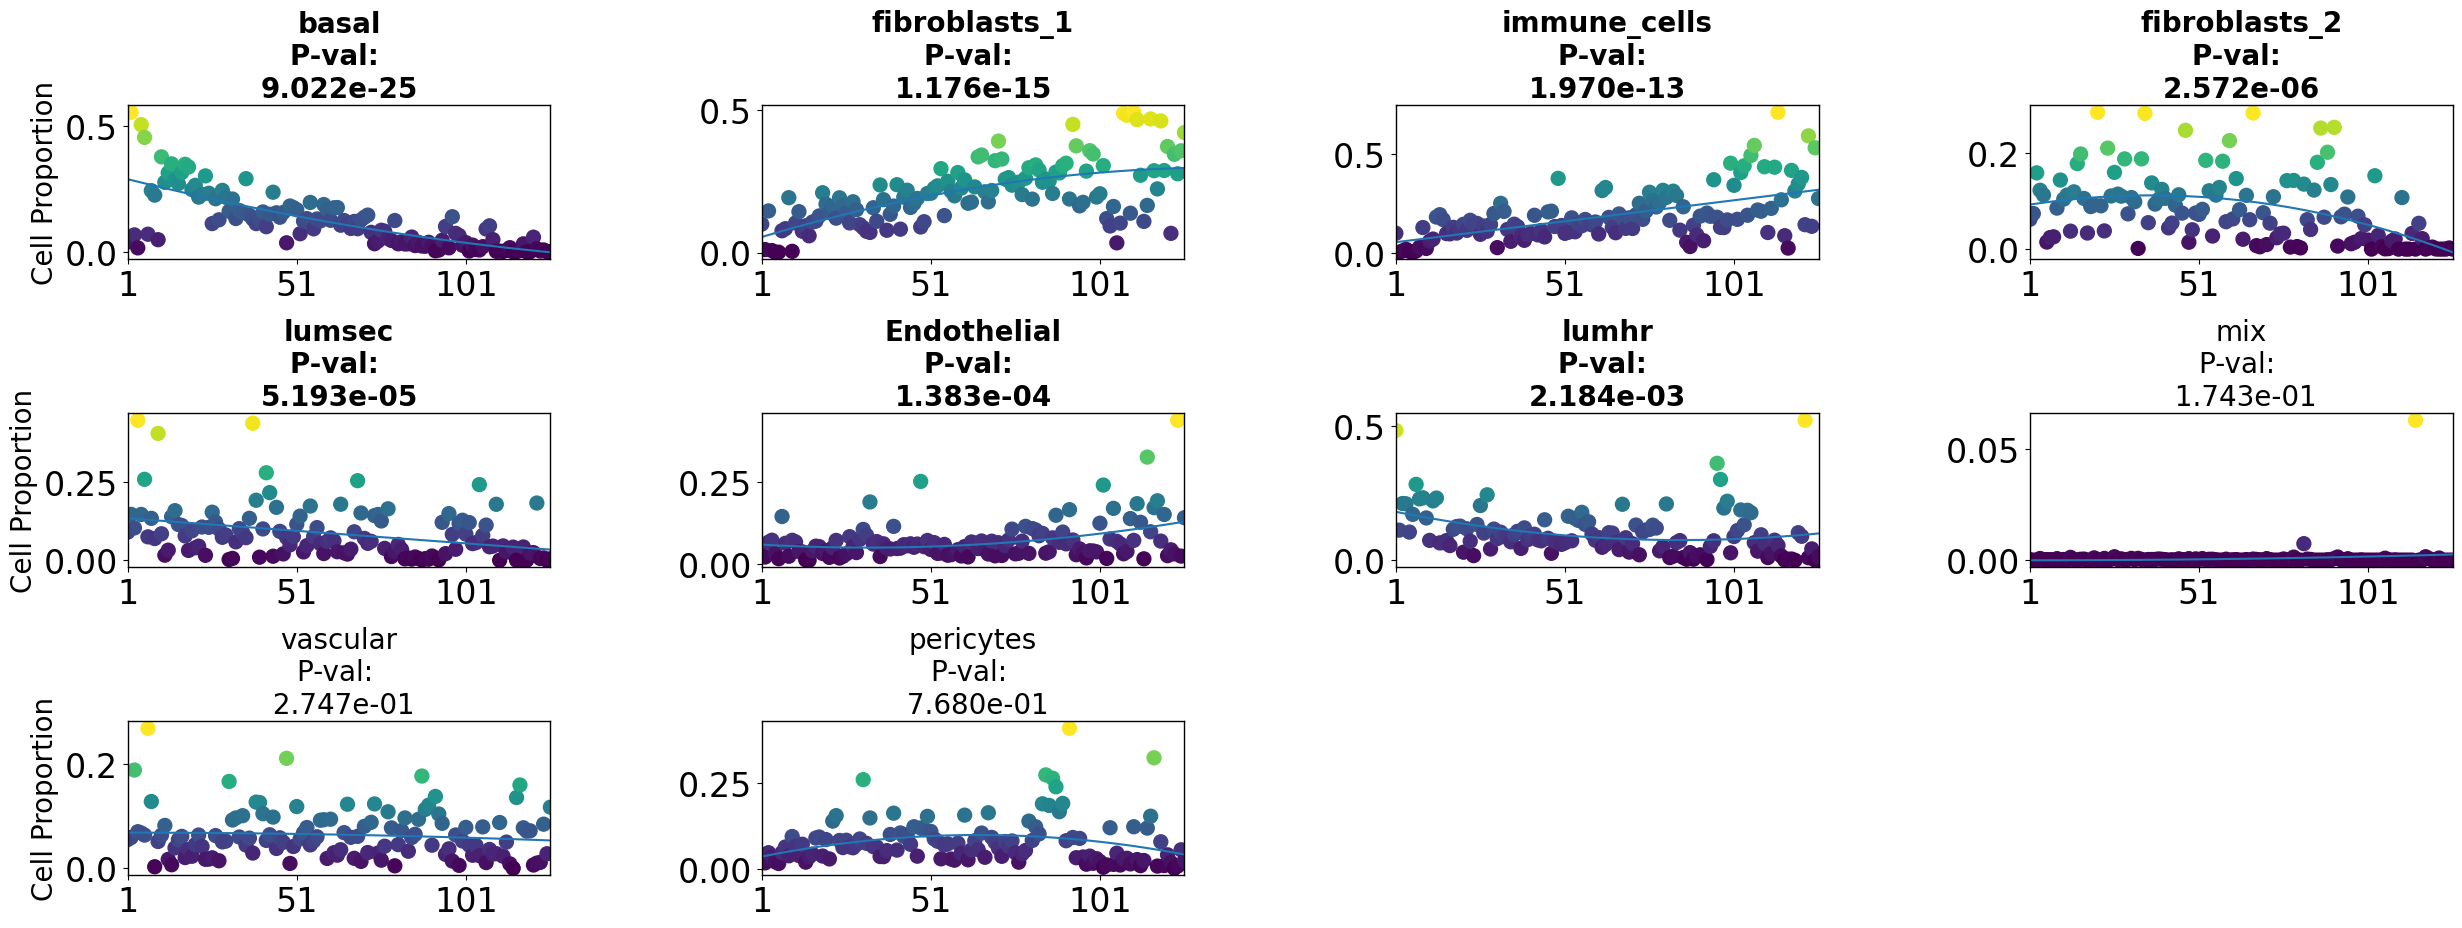

In [14]:
cell_importance(adata,width=30,height=10,xlim=50)

### Applying PILOT-GM-VAE for finding Markers

#### Gene selection: 

Given the identification of interesting components, we can investigate genes associated with these trajectories. These include genes whose expression changes linearly or quadratically with disease progression.

#### Output:
After running the command, a folder named **`Markers`** will be created. Inside this folder:
- Subfolders for each cell type will be generated.
- The file **`Whole_expressions.csv`** will contain all statistics associated with genes for each cell type.

#### Process:
1. **Run `genes_importance`**:  
   This function will be executed for all cell types in the dataset.

2. **Set Required Columns**:
   - Specify the column names in your AnnData object for:
     - **Cell types/clusters**: Column representing the cell type or cluster assignments.
     - **Samples/Patients**: Column representing the sample or patient information.

#### Note:
If you are running this step on a personal computer, it might be time-intensive. To address this:
- Perform random sampling to reduce the data size and speed up the process.
- This allows for a quicker initial analysis while retaining the option to scale up for the complete dataset.

By investigating the selected genes, you can identify those that are significantly associated with disease progression.


In [15]:
filtered_adata = filter_cells_by_sample_and_cell_type(adata, sample_column= 'accSample', cell_type_column= 'component_renamed')

Original number of cells: 714331
Filtered number of cells: 58161


In [16]:
for cell in filtered_adata.obs['component_renamed'].unique():
    genes_importance(filtered_adata,
    name_cell = cell,
    sample_col = 'accSample',
    col_cell = 'component_renamed',
    plot_genes = True, normalize= False,x_lim= 50)

#### Cluster-Specific Marker Changes

The previous analysis identified genes with significant changes over time for a given cell type. However, it did not account for whether similar patterns and expression values exist in other clusters.

To refine the selection of genes, we use a **Wald test** that compares:
- The fit of a gene within a specific cluster.
- The fit of the same gene in other clusters.

This test allows us to identify **cluster-specific marker genes** with unique patterns of expression.

#### Process:
1. **Gene Selection**:  
   - Focus on the top genes for each cell type based on the regression fit.
   - Use the Wald test to compare gene expression patterns across clusters.

2. **Purpose**:  
   - Ensure selected genes are unique to specific clusters.
   - Filter out genes with similar expression patterns across multiple clusters, improving the specificity of the results.

#### Example: Focusing on Fibroblast Components
In this example, we specifically analyze the **fibroblast components** to identify unique marker genes associated with these clusters. The following command achieves this:



In [17]:
gene_cluster_differentiation(filtered_adata,cellnames =['fibroblasts_1','fibroblasts_2'], number_genes = 70)

#### Test Results and Final Gene List of Fibroblasts_1

The test results of previous step are saved in the file **`gene_clusters_stats_extend.csv`**. To derive the final list of genes, we apply the following criteria:

1. **Fold Change (FC)**:  
   - Only consider genes with a fold change (FC) higher than 0.5, indicating that their expression is significantly increased in the cluster of interest.

2. **Sorting**:  
   - Sort the selected genes based on the Wald test to prioritize genes with the strongest statistical significance.

In [19]:
df=results_gene_cluster_differentiation(cluster_name = 'fibroblasts_1',threshold= 0.5)
df

,gene,cluster,waldStat,pvalue,FC,Expression pattern,fit-pvalue,fit-mod-rsquared,Ens_ID
2151,C1R,fibroblasts_1,3186.126544,0.000000e+00,0.844178,linear up,2.263724e-30,0.530693,ENSG00000159403
1242,C3,fibroblasts_1,6097.773752,0.000000e+00,3.539939,linear up,1.739459e-147,0.552095,ENSG00000125730
1034,CTGF,fibroblasts_1,2284.384442,0.000000e+00,1.613504,quadratic down,2.621064e-11,0.537720,ENSG00000118523
1955,GSN,fibroblasts_1,1230.408069,1.851825e-266,1.653654,quadratic up,4.795398e-142,0.586143,ENSG00000148180
2209,COL6A3,fibroblasts_1,1061.273580,3.526714e-231,1.145199,quadratic up,2.026401e-51,0.534161,ENSG00000163359
3530,SELENOP,fibroblasts_1,996.134229,1.240894e-215,1.674885,linear up quadratic down,5.518181e-07,0.516515,ENSG00000250722
1866,SFRP2,fibroblasts_1,640.471545,1.695265e-138,0.779975,linear up quadratic down,5.579741e-44,0.561533,ENSG00000145423
3105,CFD,fibroblasts_1,467.799339,4.534813e-101,3.632682,quadratic up,1.084220e-166,0.647825,ENSG00000197766
1535,ANXA1,fibroblasts_1,391.372626,1.636269e-84,0.660412,linear up,7.242067e-79,0.547995,ENSG00000135046
1722,COL6A2,fibroblasts_1,345.068246,1.743926e-74,1.976507,linear down quadratic up,7.862256e-99,0.555555,ENSG00000142173


#### Clustering Genes by Pattern

We cluster the selected genes based on their expression patterns and visualize the results using a heatmap. Below the heatmap, the patterns of each gene group are depicted.

- **Statistical Scores**: Curves activities and fold changes through disease progression are saved in the **`Markers`** folder.
- **Customizing Clusters**: Use the `scaler_value` parameter to adjust the number of clusters. The default is `0.5` but can be modified for broader or more specific clustering.


Filter genes ...
Cluster genes using hierarchical clustering... 
Compute curves activities... 
Save curves activities... 
Plot the heatmap of genes clustered... 
Heatmap saved as Results_PILOT/Markers/heatmap.pdf


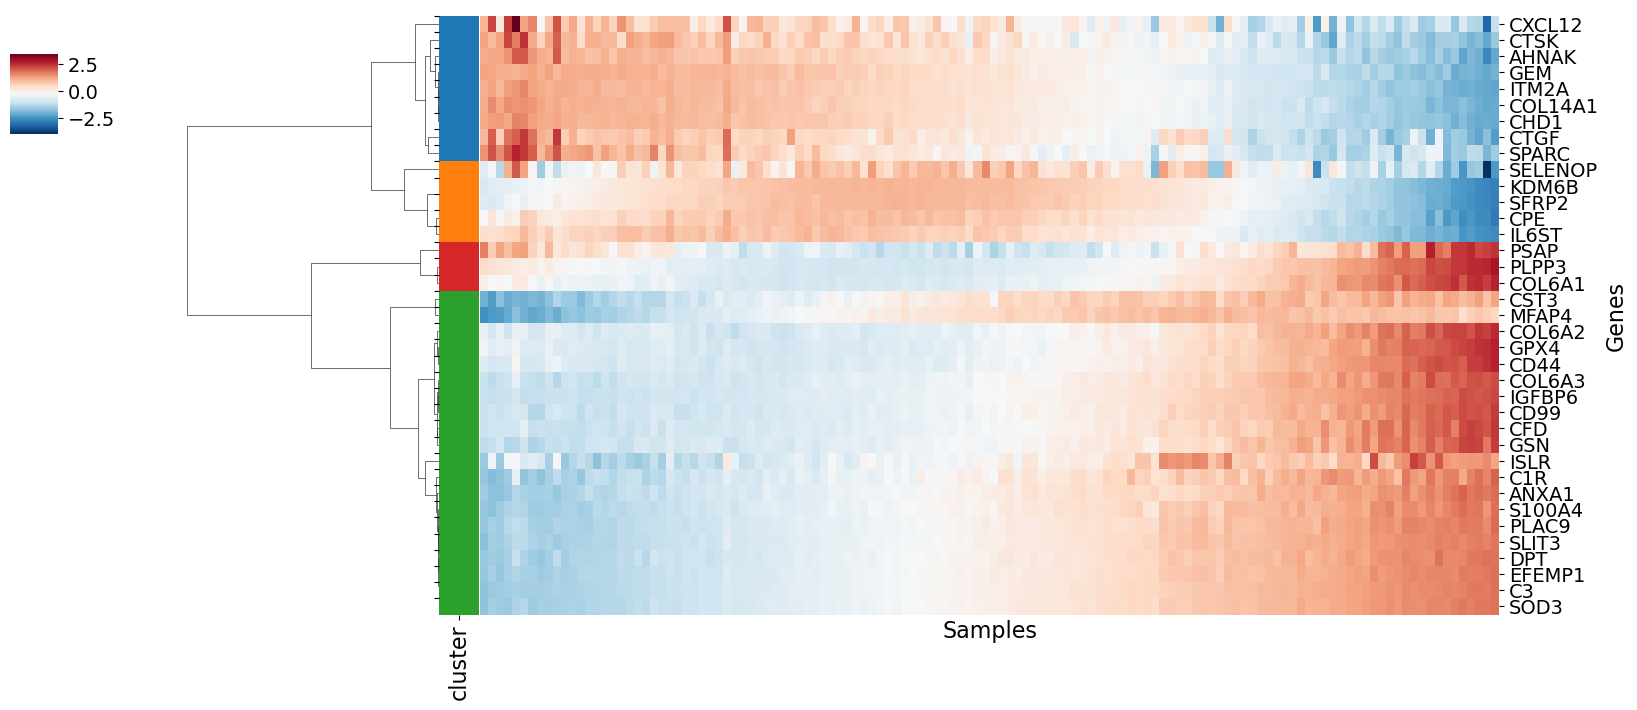

In [20]:
genes_selection_heatmap(filtered_adata, 'fibroblasts_1', scaler_value = 0.5,figsize= (16,8),df=df)

#### GO Terms Based on Clusters

We perform GO enrichment analysis for the genes in each cluster. 

- **Results**: 
  - The plots and GO terms for each cluster are saved in the **`Go/heatmap`** folder.
- **Visualization**: 
  - Heatmaps depict the enriched GO terms associated with each cluster, highlighting key biological processes.

This analysis links gene clusters to their functional roles.


Loading existing results for cluster 1...
Loading existing results for cluster 2...
Loading existing results for cluster 4...
Loading existing results for cluster 3...


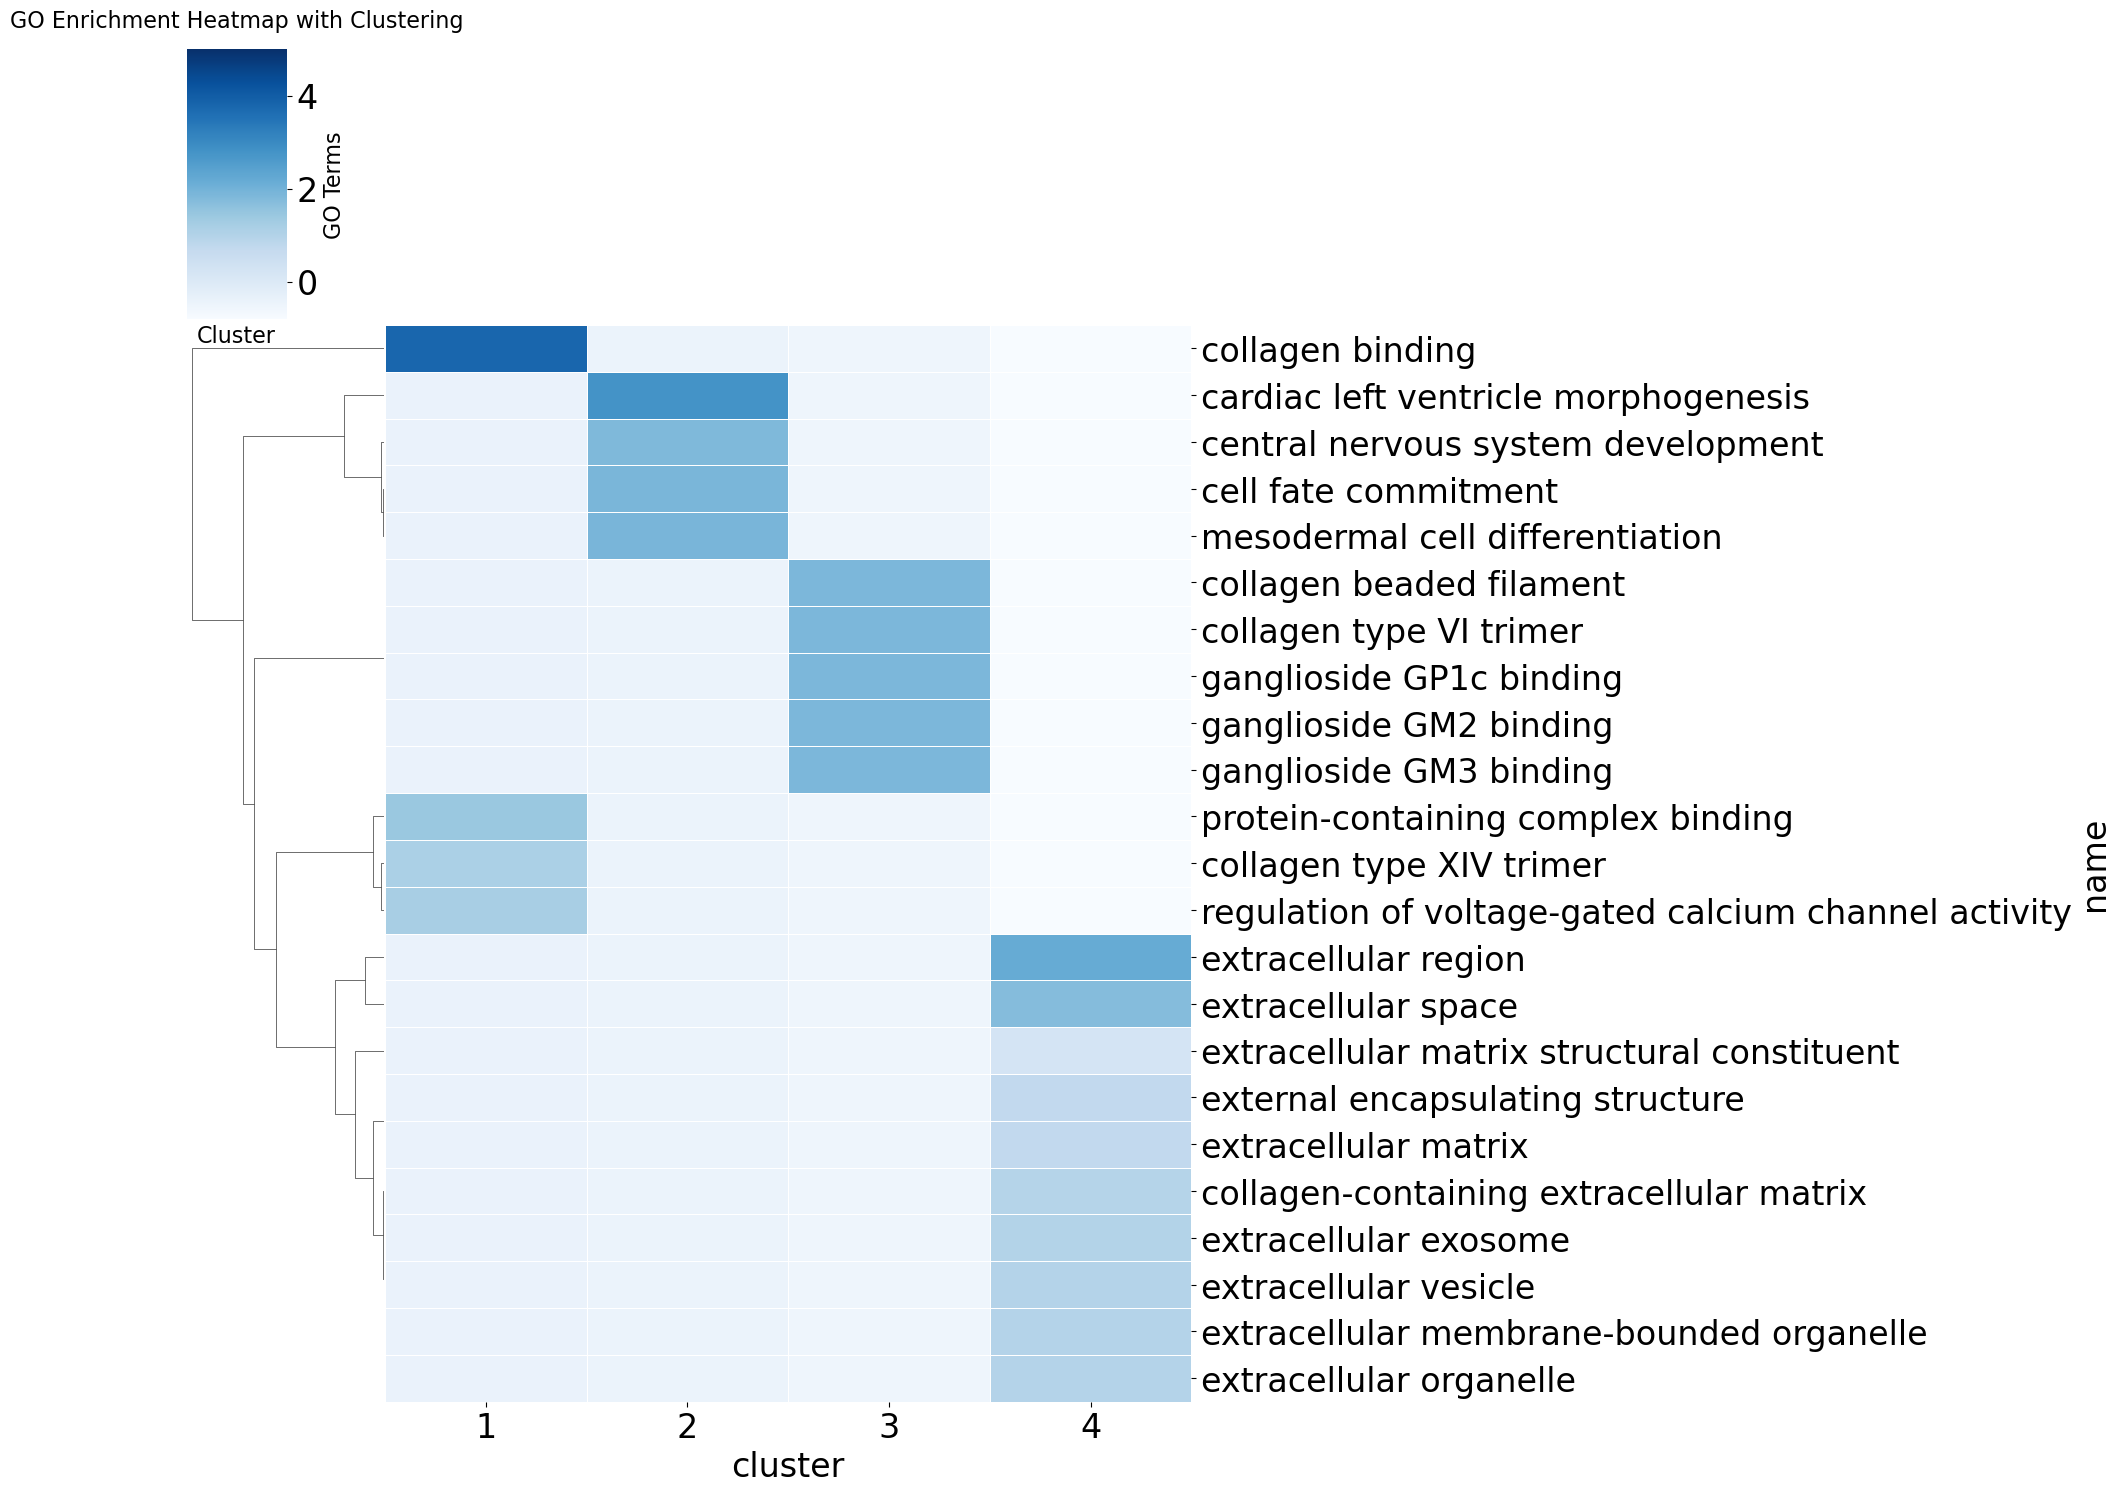

In [23]:
go_enrichment_heatmap(filtered_adata,figsize= (20,15))